In [117]:
import pandas as pd
import sys
import os
import csv
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

datasets = {'Jester': {'n_folds': 8,
                       'evaluation_methods': ['MSE', 'AUROC']
                      }, 
            'Epinions': {'n_folds': 8,
                         'evaluation_methods': ['F1', 'AUROC']
                        },
            'Cora': {'n_folds': 8, 
                     'evaluation_methods': ['F1', 'Accuracy']
                    },
            'Citeseer': {'n_folds': 8, 
                         'evaluation_methods': ['F1', 'Accuracy']
                        },
            'LastFM': {'n_folds': 5, 
                       'evaluation_methods': ['MSE', 'AUROC']
                      }
           }

# weight_learning_methods = ["BOWLSS", "BOWLOS", "LME", "MLE",
#            "MPLE", "RGS", "CRGS", "HB"]

weight_learning_methods = {"psl": ["BOWLSS", "BOWLOS", "UNIFORM"],
                           "tuffy": ["UNIFORM"]}

In [2]:
!pwd

/scratch/charles/SRLWeightLearning/scripts


In [118]:
# dataset="epinions"
# wl_method="UNIFORM"
# evaluation_metric="Discrete"
# fold=0
# predicate="trusts"

# dataset="citeseer"
# wl_method="UNIFORM"
# evaluation_metric="Categorical"
# fold=0
# predicate="hasCat"

dataset="jester"
wl_method="UNIFORM"
evaluation_metric="Continuous"
fold=0
predicate="rating"

In [119]:
def load_truth_frame(dataset, fold, predicate):
    # truth dataframe 
    truth_path = "../psl-examples/{}/data/{}/{}/eval/{}_truth.txt".format(dataset, dataset, fold, predicate)
    truth_df = pd.read_csv(truth_path, sep='\t', header=None)
    
    # clean up column names and set multi-index for predicate
    arg_columns = ['arg_' + str(col) for col in truth_df.columns[:-1]]
    value_column = ['val']
    truth_df.columns = arg_columns + value_column
    truth_df = truth_df.astype({col: int for col in arg_columns})
    truth_df = truth_df.set_index(arg_columns)
    
    return truth_df

In [120]:
def get_psl_experiment_prediction_frame(dataset, wl_method, evaluation_metric, fold, predicate):
    
    # predicted dataframe 
    predicted_path = "../results/weightlearning/psl/performance_study/{}/{}/{}/{}/inferred-predicates/{}.txt".format(
        dataset, wl_method, evaluation_metric, fold, predicate.upper())
    predicted_df = pd.read_csv(predicted_path, sep='\t', header=None)

    # clean up column names and set multi-index for predicate
    arg_columns = ['arg_' + str(col) for col in predicted_df.columns[:-1]]
    value_column = ['val']
    predicted_df.columns = arg_columns + value_column
    predicted_df = predicted_df.astype({col: int for col in arg_columns})
    predicted_df = predicted_df.set_index(arg_columns)

    # truth dataframe 
    truth_df = load_truth_frame(dataset, fold, predicate)

    # Join predicted_df and truth_df on the arguments
    prediction_frame = truth_df.join(predicted_df, how="left",
                                     lsuffix='_truth', rsuffix='_predicted').fillna(0)

    return prediction_frame

In [121]:
def load_file(filename):
    output = []

    with open(filename, 'r') as tsvfile:
        reader = csv.reader(tsvfile, delimiter='\t')
        for line in reader:
            output.append(line)

    return output

def load_tuffy(tuffy_dir):
    results_path = os.path.join(tuffy_dir, 'inferred-predicates.txt')
    results_tmp = load_file(results_path)
    results = []
    
    for result in results_tmp:
        if len(result) == 1:
            # then we did not run in marginal mode, i.e. outputs in this file are all "true" or 1
            predicate = result[0][result[0].find("(")+1:result[0].find(")")].replace(' ', '').split(',')
            predicate.append(1.0)
            results.append(predicate)
        else:
            # we ran this experiment in marginal mode, i.e., the marginal probability precedes the ground atom
            predicate = result[1][result[1].find("(")+1:result[1].find(")")].replace(' ', '').split(',')
            predicate.append(result[0])
            results.append(predicate)

    return results

def get_tuffy_experiment_prediction_frame(dataset, wl_method, evaluation_metric, fold, predicate):
    
    # read inferred and truth data
    tuffy_experiment_directory = "../results/weightlearning/tuffy/performance_study/{}/{}/{}/{}".format(
        dataset, wl_method, evaluation_metric, fold)

    results = load_tuffy(tuffy_experiment_directory)
    predicted_df = pd.DataFrame(results)

    # clean up column names and set multi-index for predicate
    arg_columns = ['arg_' + str(col) for col in predicted_df.columns[:-1]]
    value_column = ['val']
    predicted_df.columns = arg_columns + value_column
    predicted_df = predicted_df.astype({col: int for col in arg_columns})
    predicted_df = predicted_df.set_index(arg_columns)

    # truth dataframe 
    truth_df = load_truth_frame(dataset, fold, predicate)

    # Join predicted_df and truth_df on the arguments
    prediction_frame = truth_df.join(predicted_df, how="left",
                                     lsuffix='_truth', rsuffix='_predicted').fillna(0)

    return prediction_frame

In [128]:
prediction_frame = get_psl_experiment_prediction_frame(dataset, wl_method, evaluation_metric, fold, predicate)

In [125]:
def evaluate_mse(predictions, truths):
    mse = {"mse": mean_squared_error(truths, predictions)}
    return mse


def evaluate_accuracy(predictions, truths):
    accuracy = {"accuracy": accuracy_score(truths, predictions)}
    return accuracy


def evaluate_f1(predictions, truths, threshold=0.5):
    b_predictions = predictions > threshold
    b_truths = truths > threshold
    
    f_1 = {"positive_class_f1": f1_score(b_truths, b_predictions, pos_label=True),
           "negative_class_f1": f1_score(b_truths, b_predictions, pos_label=False)}

    return f_1

def evaluate_roc_auc_score(predictions, truths, threshold=0.5):
    relevant = truths > threshold
    auroc = {"auroc": roc_auc_score(relevant, predictions)}
    return auroc

In [ ]:
def write_psl_experiment_performance_results(dataset, wl_method, metric, n_folds):
    # for each metric in the evaluator type make a series with the index representing the fold and value the outcome
    

In [136]:
def write_psl_performance_results():
    # in results/weightlearning/psl/performance_study write 
    # a performance.csv file with columns 
    # Dataset | WL_Method | Evaluation_Method | Mean | Standard_Deviation
    
    # we are going to overwrite the file with all the most up to date information
    
    psl_performance_frame = pd.DataFrame(columns=['Dataset', 'Wl_Method', 'Evaluation_Method', 'Mean', 'Standard_Deviation'])
    
    # find all the files that are in the results directory
    path = '../results/weightlearning/psl/performance_study'
    datasets = [dataset for dataset in os.listdir(path) if os.path.isdir(os.path.join(path, dataset))]
    
    # iterate over all datasets adding the results to the psl_performance_frame
    for dataset in datasets:
        # find all the files that are in the results directory
        path = '../results/weightlearning/psl/performance_study'
        datasets = [dataset for dataset in os.listdir(path) if os.path.isdir(os.path.join(path, dataset))]

In [137]:
path = '../results/weightlearning/psl/performance_study'
datasets = [dataset for dataset in os.listdir(path) if os.path.isdir(os.path.join(path, dataset))]
datasets

['jester']

In [19]:
# build single dataframe for each dataset
for dataset_name in datasets.keys():
    datasets[dataset_name]["dataframe"] = pd.DataFrame(index=range(datasets[dataset_name]["n_folds"]));
    datasets[dataset_name]["dataframe"].index.name = 'fold'
    for evaluation_method in datasets[dataset_name]["evaluation_methods"]:
        for wl_method in weight_learning_methods:
            results = pd.read_csv(dataset_name + '/' + dataset_name + "-" + wl_method + "-eval-" + evaluation_method + ".csv", header=None).values[0]
            results = results[:datasets[dataset_name]['n_folds']]
            datasets[dataset_name]["dataframe"][evaluation_method + "_" + wl_method] = results

columns=set()
for dataset_name in datasets.keys():
    for evaluation_method in datasets[dataset_name]["evaluation_methods"]:
        columns.add(dataset_name + '_' + evaluation_method + '_mean')
        columns.add(dataset_name + '_' + evaluation_method + '_standardDeviation')

performance_dataframe = pd.DataFrame(index=weight_learning_methods, columns=columns)
for wl_method in weight_learning_methods:
    for dataset_name in datasets.keys():
        for evaluation_method in datasets[dataset_name]["evaluation_methods"]:
            results = pd.read_csv(dataset_name + '/' + dataset_name + "-" + wl_method + "-eval-" + evaluation_method + ".csv", header=None).values[0]
            results = results[:datasets[dataset_name]['n_folds']]
            performance_dataframe.loc[wl_method, dataset_name + '_' + evaluation_method + '_mean'] = results.mean()
            performance_dataframe.loc[wl_method, dataset_name + '_' + evaluation_method + '_standardDeviation'] = results.std()
            
performance_dataframe = performance_dataframe.reindex(sorted(performance_dataframe.columns), axis=1)
performance_dataframe.to_csv("performance_study_results.csv")

In [18]:
performance_dataframe

,Citeseer_Accuracy_mean,Citeseer_Accuracy_standardDeviation,Citeseer_F1_mean,Citeseer_F1_standardDeviation,Cora_Accuracy_mean,Cora_Accuracy_standardDeviation,Cora_F1_mean,Cora_F1_standardDeviation,Epinions_AUROC_mean,Epinions_AUROC_standardDeviation,Epinions_F1_mean,Epinions_F1_standardDeviation,Jester_AUROC_mean,Jester_AUROC_standardDeviation,Jester_MSE_mean,Jester_MSE_standardDeviation,LastFM_AUROC_mean,LastFM_AUROC_standardDeviation,LastFM_MSE_mean,LastFM_MSE_standardDeviation
RGS,0.741013,0.0117652,0.797617,0.00695118,0.83299,0.014448,0.866319,0.0148332,0.811908,0.0302242,0.964475,0.00568882,0.769814,0.00155714,0.0521525,0.000476229,0.598016,0.00459492,0.078146,0.000922336
CRGS,0.744561,0.0106014,0.788449,0.00798026,0.833914,0.0176771,0.855506,0.0115167,0.814475,0.0217344,0.957941,0.00634273,0.771078,0.00151763,0.0552375,0.000269525,0.594382,0.0018314,0.091716,0.000832697
HB,0.743052,0.00880311,0.785321,0.00770918,0.836037,0.0152339,0.857889,0.0099019,0.808821,0.0224004,0.957346,0.00581896,0.7709,0.00151919,0.0571412,0.000176028,0.594382,0.0018314,0.091716,0.000832697


In [2]:
for dataset_name in datasets.keys():
    datasets[dataset_name]["dataframe"] = pd.DataFrame(index=range(datasets[dataset_name]["n_folds"]));
    datasets[dataset_name]["dataframe"].index.name = 'fold'
    for evaluation_method in datasets[dataset_name]["evaluation_methods"]:
        for wl_method in weight_learning_methods:
            results = pd.read_csv(dataset_name + '/' + dataset_name + "-" + wl_method + "-eval-" + evaluation_method + ".csv", header=None).values[0]
            results = results[:datasets[dataset_name]['n_folds']]
            datasets[dataset_name]["dataframe"][evaluation_method + "_" + wl_method] = results

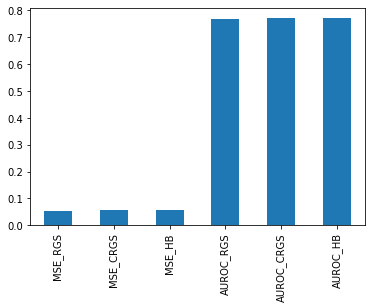

In [6]:
dataset_name = 'Jester'
datasets[dataset_name]["dataframe"].mean().plot(kind='bar')

In [72]:
columns=set()
for dataset_name in datasets.keys():
    for column in datasets[dataset_name]['dataframe'].columns:
        columns.add(column)

In [78]:
mean_dataframe = pd.DataFrame(columns=columns)
standard_deviation_dataframe = pd.DataFrame(columns=columns)

In [79]:
for dataset_name in datasets.keys():
    mean_series = datasets[dataset_name]['dataframe'].mean()
    mean_series.name = dataset_name
    mean_dataframe = mean_dataframe.append(mean_series)
    
    standard_deviation_series = datasets[dataset_name]['dataframe'].std()
    standard_deviation_series.name = dataset_name
    standard_deviation_dataframe = standard_deviation_dataframe.append(standard_deviation_series)

In [90]:
performance_dataframe = standard_deviation_dataframe.join(mean_dataframe, lsuffix='_std', rsuffix='_mean')
performance_dataframe = performance_dataframe.reindex(sorted(performance_dataframe.columns), axis=1)
performance_dataframe.to_csv("performance_study_results.csv")

In [68]:
mean_dataframe

,RGS_MSE,CRGS_F1,HB_MSE,HB_F1,RGS_F1,RGS_Accuracy,HB_Accuracy,CRGS_MSE,CRGS_Accuracy,RGS_AUROC,HB_AUROC,CRGS_AUROC
Jester,0.052152,NaN,0.057141,NaN,NaN,NaN,NaN,0.055238,NaN,0.769814,0.770900,0.771078
Epinions,NaN,0.957941,NaN,0.957346,0.964475,NaN,NaN,NaN,NaN,0.811908,0.808821,0.814475
Cora,NaN,0.855506,NaN,0.857889,0.866319,0.832990,0.836037,NaN,0.833914,NaN,NaN,NaN
Citeseer,NaN,0.788449,NaN,0.785321,0.797617,0.741013,0.743053,NaN,0.744561,NaN,NaN,NaN
LastFM,0.078146,NaN,0.091716,NaN,NaN,NaN,NaN,0.091716,NaN,0.598016,0.594382,0.594382


In [26]:
columns

{'1', '2'}

In [10]:
l=[0,12]

In [12]:
l.mean()

AttributeError: 'list' object has no attribute 'mean'